# Derviving and implmenting resnet2resnet transformations

TODO: Describe zero initializations

TODO: Define the two convolutions 

TODO: describe extending a kernel with C1 filters, and extending with 2\*C2 filters. Where we initialize to W and -W

TODO: Initialization of a new identity layer (net2deeper transform) is the same as a net2wider transform, with C1 = 0.

TODO: Describe why this doesn't work, because it only works with odd activation functions (i.e. tanh). This is obviously too restrictive.

TODO: describe initializing with W and W, and then adding the $beta$ and $-beta$ on a 1x1 conv

TODO: describe the additional benefit of the 1x1 convs to provide a consistent dimension on the output

TODO: Add our final diagrams to help explain

## Preamble

Here's just some code to make matplotlib libraries etc play nice with jupyter notebooks. (So we just run the below code and don't worry about how it works).

This will setup plotting how we want it, make matplotlib and seaborn figures run inline.

In [62]:
# Some imports
import random
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Seaborn config
sns.set(color_codes=True)

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initializing the kernel

Here we provide the code to zero initialize a module. We begin by defining the normal (Xavier and He) initializations for numpy arrays, and extend them to provide initializations for "widennings" of convolutional filters. The aim for this portion of the notebook is to take a set of convolutional filters F, and initialize further filters, W, and return a concatenated set of filters, [F;W;W]. (N.B. we use ';' for concatenation).

In [1]:
# import the tensorflow and numpy libraries we need now
import tensorflow as tf
import numpy as np

/media/michael/DATA1/anaconda/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def conv_xavier_initialize(filter_shape, override_output_channels=None):
    """
    Initialize a convolutional filter, with shape 'filter_shape', according to "He initialization".
    The weight for each hidden unit should be drawn from a normal distribution, with zero mean and stddev of 
    sqrt(2/(n_in + n_out)).
    
    This is the initialization of choice for layers with non ReLU activations.
    
    The filter shape should be [width, height, input_channels, output_channels]. So here, n_in = input_channels 
    and n_out = width * height * output_channels.
    
    When "widening" an filter, from C1 output filters, to C1 + 2*C2 filters, then we want to initialize the 
    additional 2*C2 layers, as if there are C1+2*C2 filters in the output, and therefore we provide the 
    option to override the number of output filters.
    
    :param filter_shape: THe shape of the filter that we want to produce an initialization for
    :param override_output_channels: Override for the number of output filters in the filter_shape (optional)
    :return: A numpy array, of shape 'filter_shape', randomly initialized according to He initialization.
    """
    width, height, in_channels, out_channels
    if override_output_channels is not None:
        out_channels = override_output_channels
    filter_shape = (width, height, in_channels, out_channels)    
    
    scale = np.sqrt(2.0 / (in_channels + width*height*out_chanels))
    return scale * np.random.randn(*filter_shape).astype(np.float32) 
    
    
    
    

def conv_he_initialize(filter_shape):
    """
    Initialize a convolutional filter, with shape 'filter_shape', according to "Xavier initialization".
    Each weight for each hidden unit should be drawn from a normal distribution, with zero mean and stddev of 
    sqrt(2/n_in).
    
    This is the initialization of choice for layers with ReLU activations.
    
    The filter shape should be [width, height, input_channels, output_channels]. So here, n_in = input_channels.
    
    As the initization only depends on the number of inputs (the number of input channels), unlike Xavier 
    initialization, we don't need to be able to override the number of output_channels.
    
    :param filter_shape: THe shape of the filter that we want to produce an initialization for
    :return: A numpy array, of shape 'filter_shape', randomly initialized according to He initialization.
    """
    in_channels = filter_shape[2]
    scale = np.sqrt(2.0 / in_channels)
    return scale * np.random.randn(*filter_shape).astype(np.float32)


In [3]:
def init_filter_with_repeated_weights(extending_filter_shape, existing_filter=None, init_type='He'):
    """
    We want to initialize a filter with appropriately initialized weights.
    
    Let F be the 'existing_filter', with shape [W,H,I,C1]. Let extending_filter_shape be [W,H,I,2*C2]. 
    If the value for 2*C2 is odd or non-positive, then it's an error, if the first the
    We then want to initialize E of shape [W,H,I,C2], according to the given initialization, 
    and then we want to return the concatenation [F;E;E].
    
    To make a fresh/new filter, with repeated weights, let 'existing_filter' be None, and it will 
    return just [E;E], as F is "empty".
    
    :param extending_filter_shape: The shape of the new portion of the filter to return. I.e. [W,H,I,2*C2]
    :param existing_filter: If not None, it must have shape [W,H,I,C1], this is the existing filter.
    :param init_type: The type of initialization to use
    :return: A filter, extended by 2*C2 channels. I.e. the filter [F;E;E]
    """
    # Unpack params input
    W, H, I, twoC2 = extending_filter_shape
    C2 = twoC2 // 2
    C1 = 0 if existing_filter is None else existing_filter.shape[3]
    
    # Error checking
    if twoC2 % 2 != 0:
        # TODO: log a descriptive error in final implementation
        raise Exception()
    elif existing_filter is not None and (W != existing_filter.shape[0] 
        or H != existing_filter.shape[1] or I != existing_filter.shape[2]):
        # TODO: log a descriptive error in final implementation
        raise Exception()
    
    # Canvas for the new numpy array that we want to return, and copy existing filter weights
    canvas = np.zeros((W,H,I,C1 + twoC2)).astype(np.float32)
    if existing_filter is not None:
        canvas[:,:,:,:C1] = existing_filter

    # Initialize the new weights, and copy that into the canvas (twice)
    new_channels_weights = None
    if init_type == 'He':
        new_channels_weights = conv_he_initialize((W,H,I,C2))
    elif init_type == 'Xavier':
        new_channels_weights = conv_xavier_initialize((W,H,I,C2), C1+twoC2)
    else:
        # TODO: log a descriptive error in final implementation
        raise Exception()
    
    canvas[:,:,:,C1:C1+C2] = new_channels_weights
    canvas[:,:,:,C1+C2:C1+twoC2] = new_channels_weights

    # Done :)
    return canvas

## Putting it together

Now that we can extend a filter, with weights F, to [F;W;W], we use it to build our zero module using the following code

In [4]:
def _compute_filter_shape_v1(inputs, output_channels):
    """
    (Helper function for 'init_vero_module_v1').
    Computes the shape of the filter to be used, give the number of 'output_channels' we wish to have
    Also provides error checking!
    
    As v1 is just prototyping, we're just going to always set a filter size of 4x4.
    
    Also in v1, we completely ignore padding and stride, and let tf handle appropriate padding so that 
    the output width and height is the same as the width and height input.
    
    We check that the numbe of output channels is even, because we want the output to be symmetric in 
    the output channels. We also check that the number of output channels is at least the number of 
    input channels, because we want to add residual connections, and we can't really do that unless 
    in_channels <= out_channels
    """
    # 0th item is batch size
    width, height, in_channels = inputs.get_shape().as_list()[1:] 
    
    if output_channels % 2 != 0:
        # TODO: log a descriptive error in final implementation
        raise Exception()
    if in_channels > output_channels:
        # TODO: log a descriptive error in final implementation
        raise Exception()
    
    return (4,4, in_channels, output_channels)
    
        

def init_zero_module_v1(inputs, output_channels, add_max_pool=False, add_batch_norm=True, noise_ratio=1e-3, 
                        scope=""):
    """
    Initializes a convolutional layer such that if there are 2N filters output, then the output of filter 
    0 < i <= N is equal to output of filter N+i.

    For now, we use 4x4 convolutions, with a stride of 1, currently 2x2 max pooling, and only relu 
    non-linearity. Seeing at this is a v1 prototype!! (Note that we're anyway going to extend this from 
    one filter size to many filter sizes, as in inception networks).
    
    Also, for the the moment, we set the input and output for the 1x1 convolution at the end to use 
    'output_channels' number of channels. We can change this later to two seperate numbers, but it's 
    uninteresting (for now).
    
    In later versions, we should also allow the options for different activation functions.

    Outline of the computation that we perform:
    0. (Optionally) reduce the input dimensions, using a max pool
    1. Input shape of [A,A,D], and desired output shape is [A,A,2K]
    2. Make a filter, with shape [4,4,D,2K], where [4,4,D,:K] is identitcal to [4,4,D,K:], 
        that is: set the weights for [:,:,:,K+j] equal to  [:,:,:,j]
    3. Add noise, at an appropriate scale, to break symmetry
    4. Add batch norm, if we want to
    5. Apply our non-linearity, 
    6. By the symmetry introduced, the output after the non-linearity should be of the form [W'; W'] 
        (that is, still symmetric)
    7. Use a 1x1 convolution to use the symmetry to make the output from the previous layer cancel out 
        (note that this also allows use to provide dimensionality reduction, and, output a consistent number 
        of filters, helping to keep everything modular and all layers independent. (The next layer doesn't 
        need to change its input shape)).
    
    :param inputs: input to the zero module
    :param num_output_filters: the number of output channels to have in the output
    :param add_max_pool: should we add a max pool before anything else?
    :param add_batch_norm: should we add a batch norm layer before the activation?
    :param noise_ratio: the ratio (with respect to the max value in the filter) of noise to add
    :param scope: tensorflow variable scoping
    :return: output from the zero module
    """
    with tf.variable_scope(scope):
        # If max pooling, we apply that first
        max_pool_outputs = inputs
        if add_max_pool:
            max_pool_outputs = tf.layers.max_pooling2d(inputs, pool_size=2, strides=2)

        # Compute [A,A,D,2K], and initilize a filter using 'init_filter_with_repeated_weights'
        filter_shape = _compute_filter_shape_v1(inputs, output_channels)
        filter_init = init_filter_with_repeated_weights(filter_shape, init_type='He')

        # Actually make the filter tf variable, and make the convolutional layer
        filtr = tf.Variable(filter_init, name=scope+"/conv_filter")
        stride = 1
        conv_outputs = tf.nn.conv2d(input = inputs,
                                    filter = filtr,
                                    strides = [1,stride,stride,1],
                                    padding = "SAME")

        # Apply batch norm
        batch_norm_outputs = conv_outputs
        if add_batch_norm:
            batch_norm_outputs = tf.contrib.layers.batch_norm(conv_outputs)

        # apply relu
        relu_output = tf.nn.relu(batch_norm_outputs)
        
        # init the 1x1 reduction convolution filter, negating the second half of the *inputs*
        # for now, input_channels = output_channels (= output_channels from zero module) because lazyness
        half_filters = output_channels // 2
        filter_shape = (1, 1, output_channels, output_channels)
        filter_init = init_filter_with_repeated_weights(filter_shape, init_type='He')
        filter_init[:, :, half_filters:, :] = - filter_init[:, :, :half_filters, :]
        
        # Add noise to filter, as a ratio of the maximum entry from filter_init
        max_entry = np.max(np.abs(filter_init))
        noise_scale = noise_ratio * max_entry
        filter_init += noise_ratio * np.random.randn(*filter_shape).astype(np.float32)
        
        # apply the 1x1 convolution. With the symmetry above, this will produce a(n approximately) zero output
        reduction_filter = tf.Variable(filter_init, name=scope+"/conv_reduction_filter")
        stride = 1
        output = tf.nn.conv2d(input = relu_output,
                              filter = reduction_filter,
                              strides = [1,stride,stride,1],
                              padding = "SAME")
        
        # return, caching all of the intermediate variables, to use when "widening" this layer
        cache = [max_pool_outputs, filtr, batch_norm_outputs, relu_output, reduction_filter, output]
        return output, cache

## Sanity checking what we've done so far

Now, lets run a few tests, as follows, to sanity check that everything that we've done so far works how we intended it to.
1. Set the noise to zero, and check that the output is zero for *any* input. Initially do this without batch norm.
2. Do the same, but with batch norm added.
2. Set the noise to a small variable, and check that the output is approximately zero (and non-symmetric).
4. Repeat test 3, with batch norm 
3. To gauge the effect that noise has, run the previous test, with a number of noise ratios.
5. Repreate test 5, with batch norm

In [5]:
# Helper to make printing a little prettier :)
def indprint(string, tabs=0):
    print("\t" * tabs + string.replace('\n', '\n'+'\t'*tabs))
    
##########
# Test 1 #
##########
tf.reset_default_graph()
indprint("Test 1: Zero initialized module, no batch norm, zero noise, check with 10 different inputs that the output is zero.")
# One layer network
inputs_placeholder = tf.placeholder(shape=[None,4,4,2], dtype=tf.float32, name="input_placeholder")
output_op = init_zero_module_v1(inputs=inputs_placeholder, 
                                output_channels=4, 
                                add_max_pool=False, 
                                add_batch_norm=False, 
                                noise_ratio=0.0, 
                                scope="myscope")
output = None

# tf init
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# run with 10 different random inputs
for i in range(10):
    rand_inputs = np.random.uniform(low=-1.0, high=1.0, size=(1,4,4,2))
    feed_dict = {inputs_placeholder: rand_inputs}
    output = sess.run([output_op], feed_dict=feed_dict)
    indprint("On iter %d, average output value magnitude is %f" % (i, np.sum(np.absolute(output[0][0]))), 1)
indprint("The output from the final run was exactly this: ", 1)
indprint(np.array2string(output[0][0]), 1)

print('\n' * 4)


##########
# Test 2 #
##########
tf.reset_default_graph()
indprint("Test 2: same as test 1, with batch norm added, and max pooling added")
inputs_placeholder = tf.placeholder(shape=[None,4,4,2], dtype=tf.float32, name="input_placeholder")
output_op = init_zero_module_v1(inputs=inputs_placeholder, 
                                output_channels=4, 
                                add_max_pool=True, 
                                add_batch_norm=True, 
                                noise_ratio=0.0, 
                                scope="myscope2")
output = None

# tf init
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# run with 10 different random inputs
for i in range(10):
    rand_inputs = np.random.uniform(low=-1.0, high=1.0, size=(1,4,4,2))
    feed_dict = {inputs_placeholder: rand_inputs}
    output = sess.run([output_op], feed_dict=feed_dict)
    indprint("On iter %d, average output value magnitude is %f" % (i, np.sum(np.absolute(output[0][0]))), 1)
indprint("The output from the final run was exactly this: ", 1)
indprint(np.array2string(output[0][0]), 1)

print('\n' * 4)


##########
# Test 3 #
##########
tf.reset_default_graph()
indprint("Test 3: same as test 1, with a small amount of noise added")
inputs_placeholder = tf.placeholder(shape=[None,4,4,2], dtype=tf.float32, name="input_placeholder")
output_op = init_zero_module_v1(inputs=inputs_placeholder, 
                                output_channels=4, 
                                add_max_pool=False, 
                                add_batch_norm=False, 
                                noise_ratio=1e-3, 
                                scope="myscope3")
output = None

# tf init
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# run with 10 different random inputs
for i in range(10):
    rand_inputs = np.random.uniform(low=-1.0, high=1.0, size=(1,4,4,2))
    feed_dict = {inputs_placeholder: rand_inputs}
    output = sess.run([output_op], feed_dict=feed_dict)
    vals = (i, np.sum(np.absolute(output[0][0])), np.sum(np.absolute(output[0][0]))/np.sum(np.absolute(rand_inputs)))
    indprint("On iter %d, average output value magnitude is %f, ratio of magnitudes output/input is %f" 
             % vals, 1)
indprint("The output from the final run was exactly this: ", 1)
indprint(np.array2string(output[0][0]), 1)

print('\n' * 4)


##########
# Test 4 #
##########
tf.reset_default_graph()
indprint("Test 4: same as test 3, with batch norm")
inputs_placeholder = tf.placeholder(shape=[None,4,4,2], dtype=tf.float32, name="input_placeholder")
output_op = init_zero_module_v1(inputs=inputs_placeholder, 
                                output_channels=4, 
                                add_max_pool=False, 
                                add_batch_norm=True, 
                                noise_ratio=1e-3, 
                                scope="myscope4")
output = None

# tf init
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# run with 10 different random inputs
for i in range(10):
    rand_inputs = np.random.uniform(low=-1.0, high=1.0, size=(1,4,4,2))
    feed_dict = {inputs_placeholder: rand_inputs}
    output = sess.run([output_op], feed_dict=feed_dict)
    vals = (i, np.sum(np.absolute(output[0][0])), np.sum(np.absolute(output[0][0]))/np.sum(np.absolute(rand_inputs)))
    indprint("On iter %d, average output value magnitude is %f, ratio of magnitudes output/input is %f" 
             % vals, 1)
indprint("The output from the final run was exactly this: ", 1)
indprint(np.array2string(output[0][0]), 1)

print('\n' * 4)


##########
# Test 5 #
##########
tf.reset_default_graph()
indprint("Test 5: compare outputs, with the same input, given different noise ratios (no batch norm or max pool)")
inputs_placeholder = tf.placeholder(shape=[None,4,4,2], dtype=tf.float32, name="input_placeholder")

# fix some input
rand_inputs = np.random.uniform(low=-1.0, high=1.0, size=(1,4,4,2))
feed_dict = {inputs_placeholder: rand_inputs}

# run with 10 different magnitudes of noise
for noise in [10.0**i for i in range(-10, 2)]:
    # Make the zero module, with the desired amount of noise
    output_op = init_zero_module_v1(inputs=inputs_placeholder, 
                                    output_channels=4, 
                                    add_max_pool=False, 
                                    add_batch_norm=False, 
                                    noise_ratio=noise, 
                                    scope="myscope5")
    # tf init and run
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    output = sess.run([output_op], feed_dict=feed_dict)
    
    # analysis
    output_magnitudes = np.sum(np.absolute(output[0][0]))
    output_magnitudes_ratio = np.sum(np.absolute(output[0][0]))/np.sum(np.absolute(rand_inputs))
    vals = (noise, output_magnitudes, output_magnitudes_ratio) 
    indprint(("Noise ratio of %E, \n\tgives average output magnitude of %E," + 
             "\n\tratio of output/input magnitudes is %E") % vals, 1)

print('\n' * 4)


##########
# Test 6 #
##########
tf.reset_default_graph()
indprint("Test 6: same as test 5, with batch norm added")
inputs_placeholder = tf.placeholder(shape=[None,4,4,2], dtype=tf.float32, name="input_placeholder")

# fix some input
rand_inputs = np.random.uniform(low=-1.0, high=1.0, size=(1,4,4,2))
feed_dict = {inputs_placeholder: rand_inputs}

# run with 10 different magnitudes of noise
for noise in [10.0**i for i in range(-10, 2)]:
    # Make the zero module, with the desired amount of noise
    output_op = init_zero_module_v1(inputs=inputs_placeholder, 
                                    output_channels=4, 
                                    add_max_pool=False, 
                                    add_batch_norm=False, 
                                    noise_ratio=noise, 
                                    scope="myscope6")
    # tf init and run
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    output = sess.run([output_op], feed_dict=feed_dict)
    
    # analysis
    output_magnitudes = np.sum(np.absolute(output[0][0]))
    output_magnitudes_ratio = np.sum(np.absolute(output[0][0]))/np.sum(np.absolute(rand_inputs))
    vals = (noise, output_magnitudes, output_magnitudes_ratio) 
    indprint(("Noise ratio of %E, \n\tgives average output magnitude of %E," + 
             "\n\tratio of output/input magnitudes is %E") % vals, 1)

print('\n' * 4)

Test 1: Zero initialized module, no batch norm, zero noise, check with 10 different inputs that the output is zero.
	On iter 0, average output value magnitude is 0.000000
	On iter 1, average output value magnitude is 0.000000
	On iter 2, average output value magnitude is 0.000000
	On iter 3, average output value magnitude is 0.000000
	On iter 4, average output value magnitude is 0.000000
	On iter 5, average output value magnitude is 0.000000
	On iter 6, average output value magnitude is 0.000000
	On iter 7, average output value magnitude is 0.000000
	On iter 8, average output value magnitude is 0.000000
	On iter 9, average output value magnitude is 0.000000
	The output from the final run was exactly this: 
	[[[[0. 0. 0. 0.]
	   [0. 0. 0. 0.]
	   [0. 0. 0. 0.]
	   [0. 0. 0. 0.]]
	
	  [[0. 0. 0. 0.]
	   [0. 0. 0. 0.]
	   [0. 0. 0. 0.]
	   [0. 0. 0. 0.]]
	
	  [[0. 0. 0. 0.]
	   [0. 0. 0. 0.]
	   [0. 0. 0. 0.]
	   [0. 0. 0. 0.]]
	
	  [[0. 0. 0. 0.]
	   [0. 0. 0. 0.]
	   [0. 0. 0. 0.]
	   [

	Noise ratio of 1.000000E-10, 
		gives average output magnitude of 0.000000E+00,
		ratio of output/input magnitudes is 0.000000E+00
	Noise ratio of 1.000000E-09, 
		gives average output magnitude of 0.000000E+00,
		ratio of output/input magnitudes is 0.000000E+00
	Noise ratio of 1.000000E-08, 
		gives average output magnitude of 1.050532E-06,
		ratio of output/input magnitudes is 7.287141E-08
	Noise ratio of 1.000000E-07, 
		gives average output magnitude of 1.569092E-05,
		ratio of output/input magnitudes is 1.088420E-06
	Noise ratio of 1.000000E-06, 
		gives average output magnitude of 1.205222E-04,
		ratio of output/input magnitudes is 8.360166E-06
	Noise ratio of 1.000000E-05, 
		gives average output magnitude of 1.771390E-03,
		ratio of output/input magnitudes is 1.228746E-04
	Noise ratio of 1.000000E-04, 
		gives average output magnitude of 1.401098E-02,
		ratio of output/input magnitudes is 9.718888E-04
	Noise ratio of 1.000000E-03, 
		gives average output magnitude of 1.173941E

## Adding residual connections and using zero initializations to initialize layers to identity transforms

When we add residual connections over layers. When we have residual connections, our neural network learns a function $F(x)$, and the output is $h(x) = x + F(x)$. If we initialize $F(x)$ such that for all $x$ we have $F(x) = 0$, then we have $h(x)=x$ for any $x$, and therefore $h$ is the identity transform.

In [6]:
def identity_resnet_module_v1(inputs, output_channels, add_batch_norm=True, noise_ratio=1e-3, scope=""):
    """
    Uses init_zero_module_v1 to initialize a neural network 
    
    As this is a v1, we will zero initialize a 2 layer network, and then add a residual connection over it.
    To do this, we do the following:
    1. initialize an arbitrary layer
    2. initialize a zero initialized convolution ontop of the first (this is F(x))
    3. add the input to the output, to add the residual connection (to get x + F(x))
    
    Again, as this is a prototype, we add some arbitrary choices. For example, the number of channels from 
    each layer are [input_channels, output_channels, output_channels]
    
    Also no max pooling
    
    :param inputs: input to the zero module
    :param num_output_filters: the number of output channels to have in the output
    :param add_max_pool: should we add a max pool before anything else?
    :param add_batch_norm: should we add a batch norm layer before the activation?
    :param noise_ratio: the ratio (with respect to the max value in the filter) of noise to add
    :param scope: tensorflow variable scoping
    :return: output from the zero module
    """
    with tf.variable_scope(scope):
        # nn layer 1, he initialized
        initer = tf.contrib.layers.variance_scaling_initializer(factor=2.0)
        linear = tf.layers.conv2d(inputs, output_channels, [4,4], padding="SAME", kernel_initializer=initer, name="resnet_layer1")
        batch_norm = linear
        if add_batch_norm: 
            batch_norm = tf.contrib.layers.batch_norm(linear)
        relu_out = tf.nn.relu(batch_norm)
        
        # nn layer 2, zero initialized
        network_out, _ = init_zero_module_v1(relu_out, output_channels, add_max_pool=False, 
                                             add_batch_norm=add_batch_norm, noise_ratio=noise_ratio, 
                                             scope="resnet_layer2")
        
        # residual connection (pad inputs with zeros to match output shape)
        resnet_out = network_out 
        in_channels = inputs.get_shape().as_list()[3] # inputs.shape = [batchsize, width, height, in_channels]
        paddings = ((0,0), (0,0), (0,0), (0,max(0,output_channels - in_channels)))
        output = resnet_out + tf.pad(inputs, paddings, 'CONSTANT')
        
        # done :)
        return output
        

## More sanity checks

So now we just do one more sanity check, which involves checking if we did indeed define an itentity operator above

In [7]:
##########
# Test 7 #
##########
tf.reset_default_graph()
indprint("Test 7: Check that the identity resnet module is indeed an identity function.")
# One layer network
inputs_placeholder = tf.placeholder(shape=[None,4,4,2], dtype=tf.float32, name="input_placeholder")
output_op = identity_resnet_module_v1(inputs=inputs_placeholder, 
                                      output_channels=6, 
                                      add_batch_norm=True, 
                                      noise_ratio=0.0, 
                                      scope="myyscope")
output = None

# tf init
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# run with 10 different random inputs
for i in range(10):
    rand_inputs = np.random.uniform(low=-1.0, high=1.0, size=(1,4,4,2))
    feed_dict = {inputs_placeholder: rand_inputs}
    output = sess.run([output_op], feed_dict=feed_dict)
    indprint("On iter %d, average difference between input and output is %f" 
             % (i, np.sum(np.absolute(output[0][:,:,:,:2] - rand_inputs))), 1)
indprint("The output from the final run was exactly this: ", 1)
indprint(np.array2string(output[0][0]), 1)

Test 7: Check that the identity resnet module is indeed an identity function.
	On iter 0, average difference between input and output is 0.000000
	On iter 1, average difference between input and output is 0.000000
	On iter 2, average difference between input and output is 0.000000
	On iter 3, average difference between input and output is 0.000000
	On iter 4, average difference between input and output is 0.000000
	On iter 5, average difference between input and output is 0.000001
	On iter 6, average difference between input and output is 0.000000
	On iter 7, average difference between input and output is 0.000000
	On iter 8, average difference between input and output is 0.000000
	On iter 9, average difference between input and output is 0.000000
	The output from the final run was exactly this: 
	[[[ 9.7768283e-01 -2.8137660e-01 -2.9802322e-08  2.9802322e-08
	    0.0000000e+00 -2.9802322e-08]
	  [-3.5484219e-01  5.0927740e-01  0.0000000e+00 -2.9802322e-08
	    0.0000000e+00  0.0000000

## Training a small netowork, with 3 resnet modules, 3 max pools, and a fc output

We constuct a small network, and check that it can learn mnist and cifar-10

The first cell below defines a training loop used to evaluate our models, the second and third cells define functions that make networks. The fourth cell uses this to train and evaluate the models a number of times. The fifth cell will print out some graphs displaying the results. 

The remaining cells in this section run the same experiment with the CIFAR-10 dataset.

TODO: cite 231n and sat how to get the dataset, and what command to run

In [52]:
# Evaluate a model
def evaluate(scores_pred_op, inputs_placeholder, labels_placeholder, dataset):
    # Make an op to compute the current accuracy over a minibatch
    correct_preds = tf.equal(tf.argmax(scores,axis=1), tf.argmax(labels_placeholder,axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    
    # construct optimizer
    ce_loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels_placeholder, logits=scores, name="celoss")
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(ce_loss)

    # training loop (saving accuracies over time)
    train_iters = 300
    epoch_len = 10
    train_accuracies = []
    test_accuracies = []
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for i in range(train_iters+1):
        xs, ys = dataset.next_batch(64)
        feed_dict = {inputs_placeholder: xs, labels_placeholder: ys}
        sess.run(train_op, feed_dict=feed_dict)

        if i % epoch_len == 0:
            train_acc = sess.run(accuracy, feed_dict=feed_dict)

            test_xs, test_ys = dataset.next_test_batch(128)
            test_feed_dict = {inputs_placeholder: test_xs, labels_placeholder: test_ys}
            test_acc = sess.run(accuracy, feed_dict=test_feed_dict)

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            
            print("(Iter %d). Current train: %0.6f, Current test: %0.6f." % (i, train_acc, test_acc))
    
    return train_accuracies, test_accuracies

In [53]:
# construct identity initialized prediction network (small)
def make_identity_init_mnist_network(inputs_placeholder, labels_placeholder):
    initer = tf.contrib.layers.variance_scaling_initializer(factor=2.0)
    
    blockone = identity_resnet_module_v1(inputs_placeholder, 16, noise_ratio=0.0, scope="layerone") # [64,32,32,16]
    blockone = tf.layers.max_pooling2d(blockone, pool_size=2, strides=2) # [64,16,16,16]
    
    blocktwo = identity_resnet_module_v1(blockone, 32, noise_ratio=0.0, scope="layertwo") # [64,16,16,32]
    blocktwo = tf.layers.max_pooling2d(blocktwo, pool_size=2, strides=2) # [64,8,8,32]
    
    blockthree = identity_resnet_module_v1(blocktwo, 64, noise_ratio=0.0, scope="layerthree") # [64,8,8,64]
    blockthree = tf.layers.max_pooling2d(blockthree, pool_size=2, strides=2) # [64,4,4,64]
    
    fc_input = tf.reshape(blockthree, (-1, 4*4*64))
    fc_hidden = tf.contrib.layers.fully_connected(fc_input, 256, weights_initializer=initer)
    scores = tf.contrib.layers.fully_connected(fc_hidden, 10, weights_initializer=initer, activation_fn=tf.identity)
    
    return scores

In [56]:
# construct a he initialized prediction network (small)
def make_he_init_mnist_network(inputs_placeholder, labels_placeholder):
    # He initializer
    initer = tf.contrib.layers.variance_scaling_initializer(factor=2.0)
        
    def res_block(inputs, channels):
        # conv layers (he initialized)
        outputs = tf.layers.conv2d(inputs, channels, [4,4], padding="SAME", kernel_initializer=initer)
        outputs = tf.contrib.layers.batch_norm(outputs)
        outputs = tf.nn.relu(outputs)
        outputs = tf.layers.conv2d(outputs, channels, [4,4], padding="SAME", kernel_initializer=initer)
        outputs = tf.contrib.layers.batch_norm(outputs)
        outputs = tf.nn.relu(outputs)
        
        # residual connection (pad inputs with zeros to match output shape)
        in_channels = inputs.get_shape().as_list()[3] # inputs.shape = [batchsize, width, height, in_channels]
        paddings = ((0,0), (0,0), (0,0), (0,max(0,channels - in_channels)))
        outputs = outputs + tf.pad(inputs, paddings, 'CONSTANT')
        
        return outputs
    
    # Actually construct network
    blockone = res_block(inputs_placeholder, 16) # [64,32,32,16]
    blockone = tf.layers.max_pooling2d(blockone, pool_size=2, strides=2) # [64,16,16,16]
    
    blocktwo = res_block(blockone, 32) # [64,16,16,32]
    blocktwo = tf.layers.max_pooling2d(blocktwo, pool_size=2, strides=2) # [64,8,8,32]
    
    blockthree = res_block(blocktwo, 64) # [64,8,8,64]
    blockthree = tf.layers.max_pooling2d(blockthree, pool_size=2, strides=2) # [64,4,4,64]
    
    fc_input = tf.reshape(blockthree, (-1, 4*4*64))
    fc_hidden = tf.contrib.layers.fully_connected(fc_input, 256, weights_initializer=initer)
    scores = tf.contrib.layers.fully_connected(fc_hidden, 10, weights_initializer=initer, activation_fn=tf.identity)
    
    return scores

In [57]:
# Reset computational graph so its fresh
tf.reset_default_graph()

# load mnist datasetimport os
import os
import sys
dataset_module_path = os.path.abspath(os.path.join('..'))
if dataset_module_path not in sys.path:
    sys.path.append(dataset_module_path)
from dataset import MnistDataset

dataset = MnistDataset(64)

# tf inputs
inputs_placeholder = tf.placeholder(shape=[None,32,32,1], dtype=tf.float32, name="input_placeholder")
labels_placeholder = tf.placeholder(shape=[None,10], dtype=tf.float32, name="labels_placeholder")

# run our initialization 5 times
our_init_results = []
our_init_results_test = []
for i in range(5):
    with tf.variable_scope("scopeee", reuse=tf.AUTO_REUSE):
        scores = make_identity_init_mnist_network(inputs_placeholder, labels_placeholder)
        accuracy_results = evaluate(scores, inputs_placeholder, labels_placeholder, dataset)
        our_init_results.append(accuracy_results[0]) # train_acc
        our_init_results_test.append(accuracy_results[1]) # test_acc

# run he initialization 5 times
he_init_results = []
he_init_results_test = []
for i in range(5):
    with tf.variable_scope("scopeeeee", reuse=tf.AUTO_REUSE):
        scores = make_he_init_mnist_network(inputs_placeholder, labels_placeholder)
        accuracy_results = evaluate(scores, inputs_placeholder, labels_placeholder, dataset)
        he_init_results.append(accuracy_results[0]) # train_acc
        he_init_results_test.append(accuracy_results[1]) # test_acc


Extracting /media/michael/DATA1/Google Drive/To Org/Courses/CS231N Convolutional Neural Networks for Visual Recognition/project/dataset/MNIST_data/train-images-idx3-ubyte.gz
Extracting /media/michael/DATA1/Google Drive/To Org/Courses/CS231N Convolutional Neural Networks for Visual Recognition/project/dataset/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /media/michael/DATA1/Google Drive/To Org/Courses/CS231N Convolutional Neural Networks for Visual Recognition/project/dataset/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /media/michael/DATA1/Google Drive/To Org/Courses/CS231N Convolutional Neural Networks for Visual Recognition/project/dataset/MNIST_data/t10k-labels-idx1-ubyte.gz
(Iter 0). Current train: 0.109375, Current test: 0.085938.
(Iter 10). Current train: 0.250000, Current test: 0.289062.
(Iter 20). Current train: 0.453125, Current test: 0.414062.
(Iter 30). Current train: 0.593750, Current test: 0.492188.
(Iter 40). Current train: 0.640625, Current test: 0.601562.
(Iter 5

(Iter 0). Current train: 0.093750, Current test: 0.085938.
(Iter 10). Current train: 0.187500, Current test: 0.265625.
(Iter 20). Current train: 0.484375, Current test: 0.468750.
(Iter 30). Current train: 0.531250, Current test: 0.546875.
(Iter 40). Current train: 0.812500, Current test: 0.710938.
(Iter 50). Current train: 0.765625, Current test: 0.789062.
(Iter 60). Current train: 0.875000, Current test: 0.796875.
(Iter 70). Current train: 0.875000, Current test: 0.820312.
(Iter 80). Current train: 0.859375, Current test: 0.812500.
(Iter 90). Current train: 0.890625, Current test: 0.828125.
(Iter 100). Current train: 0.906250, Current test: 0.851562.
(Iter 110). Current train: 0.906250, Current test: 0.914062.
(Iter 120). Current train: 0.906250, Current test: 0.914062.
(Iter 130). Current train: 0.921875, Current test: 0.921875.
(Iter 140). Current train: 0.859375, Current test: 0.867188.
(Iter 150). Current train: 0.906250, Current test: 0.945312.
(Iter 160). Current train: 0.921875

/media/michael/DATA1/anaconda/envs/cs231n/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


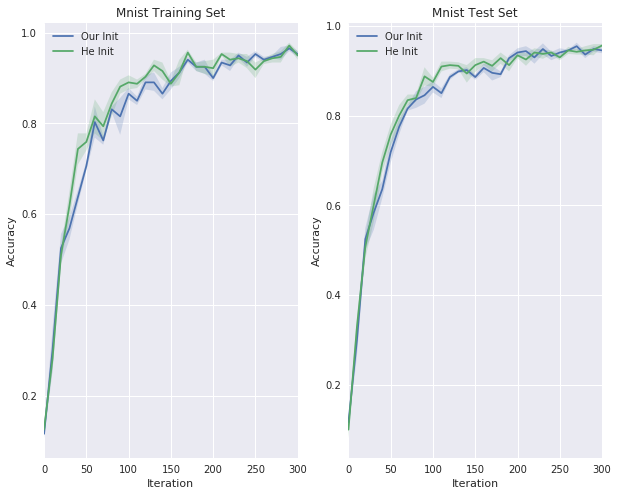

In [90]:
# Plot the results of the above tests with confidence intervals5,
# time = np.zeros((len(our_init_results),len(our_init_results[0])))
# time[:] = np.array(list(range(30)) * 10)
# print(time)
time = np.array(range(31)) * 10

plt.subplot(121)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
sns.tsplot(data=our_init_results, time=time, condition="Our Init")
sns.tsplot(data=he_init_results, time=time, color="g", condition="He Init")
plt.legend()

plt.subplot(122)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Test Set')
sns.tsplot(data=our_init_results_test, time=time, condition="Our Init")
sns.tsplot(data=he_init_results_test, time=time, color="g", condition="He Init")

In [ ]:
# TODO 4: Make the plots above nice with seaborn instead of matplot lib (repeat the code, maybe plot it with mean + stddevs)
# TODO 5: Repeat the above with CIFAR-10 (write a dataset object)
# TODO 6: Write the expanding code (new section) (write up at the start)
# TODO 7: test the split hyperparam
    """
        1. zero init (full capacity, no expandsion)
        2. normal init (full capacity, nor expansion)
        3. expand at training step (my way) at say [1000, 2000, 3000,...] (n.b. test1 = split at training step 0)
        4. expand at training step (random init) at same timesteps (n.b. not function preserving). (n.b. test2 = split at training step 0)
        5. Plot all of 1,2,3,4 on the same graph
    """
# load cifar-10


## Comparison of how identity initialized resnet modules perform compared to normal random initializations

1. Replicate the networks used above to classify mnist and cifar-10, in tf, with normal initializations
2. Compare and print out the training curvers

TODO: save plots, and plot them with seaboarn

In [ ]:
# TODO: COPY THE MATLAB CODE AT THE BEGINNING FROM THE ASSIGNMENTS..... ALSO WORK OUT HOW TO GET SEABORN WORKING IN JUPYTER ETC

# Todo list for next time:
1. net2widen operations and net2deepen operations

 1.1. Requires us to define an resnet v2. We need to be able to initialize the normal layers in the same way as the zero initialized layers (so that we can extend/widen them)
2. run, random init, vs random student (init extensions randomly) vs student (function preserving)
3. print graphs
4. run this on mnist, cifar 10
5. construct inception networks

 5.1. Requires writing v3 of all of these modules.
6. run on imagenet...